In [593]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import subprocess
import random
from tqdm import tqdm
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from classification_utils import *
from train_classification import *

# EDA

> This Code creates DataFrame with the columns:
- classfication (name of the image folder)
- image_path

In [ ]:

# Path to the dataset directory
dataset_dir = 'data/PlantVillage/'

# Function to load images and labels using OpenCV
def load_dataset(dataset_path):
    data_dict = {}
    # Walk through the dataset directory
    for root, dirs, files in os.walk(dataset_path):
        for dir_name in dirs:
            # Initialize an empty list for each subfolder
            data_dict[dir_name] = []

            # Get the full path to the subfolder
            subfolder_path = os.path.join(root, dir_name)

            # Iterate through the files in the subfolder
            for file in os.listdir(subfolder_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Construct the full path to the image
                    image_path = os.path.join(subfolder_path, file)

                    # Load the image using OpenCV
                    image = cv2.imread(image_path)
                    # Convert from BGR to RGB color space
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Append the image to the list associated with the subfolder name
                    data_dict[dir_name].append(image)
    data = [(classification, path) for classification, paths in data_dict.items() for path in paths]
    df = pd.DataFrame(data, columns=['classification', 'image'])
    return df

# Load your dataset
df = load_dataset(dataset_dir)


> Lets keep the tomatos images only

In [ ]:
for label in df.classification.unique():
    if 'tomato' in label.lower():
        print(label)

In [ ]:
tomato_data = df.loc[df['classification'].str.contains('Tomato')]
tomato_data.shape

> Sample from each classification 

In [ ]:
num_images_per_class = 4
images_to_display = []
titles = []
for label in tomato_data.classification.unique():
    label_sample = tomato_data.loc[tomato_data.classification == label].sample(num_images_per_class).image.to_list()
    images_to_display += label_sample
    titles += [label]*num_images_per_class



fig, axes = plt.subplots(nrows=len(tomato_data.classification.unique()), ncols=num_images_per_class, figsize=(15, 20))  
for ax, image, title in zip(axes.flatten(), images_to_display, titles):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
ax, fig = plt.subplots(figsize=(15,7))
sns.barplot(tomato_data.classification.value_counts().reset_index(), y='index', x='classification')
plt.yticks(fontsize=14)
plt.title("Number of images per classification", fontsize=14)
plt.show()

> Check weather the images resolution are unique

In [ ]:
tomato_data['image_shape'] = tomato_data.image.apply(lambda x: x.shape)
    
print(f"The image resolution we have in the dataset are : {tomato_data.image_shape.unique()}")

In [ ]:
segmented_data_root_folder = 'data/segmented_data/'
number_of_images_to_segment = 300

for root, dirs, files in os.walk(dataset_dir):
    for dir_name in dirs:
        if 'tomato' in dir_name.lower():
            subfolder_path = os.path.join(root, dir_name)
            destination_directory = os.path.join(segmented_data_root_folder, dir_name)
            os.makedirs(destination_directory, exist_ok=True)
            
            dir_files = os.listdir(subfolder_path)
            random_files = random.sample(dir_files, min(number_of_images_to_segment, len(dir_files)))
        else: continue
        for file in random_files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(subfolder_path, file)
                command = [
                        "python3", "leaf-image-segmentation/segment.py",
                        "-d", destination_directory,
                        "-f", "flood",  
                        image_path
                    ]
                subprocess.run(command)


In [ ]:
segmented_data = load_dataset('data/segmented_data/')
segmented_data_dict = [(classification, image) for classification, images in segmented_data.items() for image in images]
segmented_data_df = pd.DataFrame(segmented_data_dict, columns=['classification', 'image'])

In [ ]:
num_images_per_class = 4
images_to_display = []
titles = []
for label in segmented_data_df.classification.unique():
    label_sample = segmented_data_df.loc[segmented_data_df.classification == label].sample(num_images_per_class).image.to_list()
    images_to_display += label_sample
    titles += [label]*num_images_per_class



fig, axes = plt.subplots(nrows=len(segmented_data_df.classification.unique()), ncols=num_images_per_class, figsize=(15, 20))  
for ax, image, title in zip(axes.flatten(), images_to_display, titles):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def convert_rgb_to_hsv(rgb_image):
    # Convert the RGB image to HSV
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

# Apply the conversion function to each image in the DataFrame
segmented_data_df['hsv_image'] = segmented_data_df['image'].apply(convert_rgb_to_hsv)

In [ ]:
plt.imshow(segmented_data_df.hsv_image.iloc[600])

In [ ]:
plt.imshow(segmented_data_df.hsv_image.iloc[600])


In [ ]:
segmented_data_df.hsv_image.iloc.reshape(-1, 3)

In [ ]:
from sklearn.cluster import KMeans

pixels = segmented_data_df.hsv_image.iloc[0].reshape(-1, 3)
kmeans = KMeans(n_clusters=3)
kmeans.fit(pixels)



# Tomato Disease Classification

In [ ]:
lr = 0.001
b1 = 0.95
b2 = 0.99
num_epochs = 20
train_data ,val_data, test_data = get_dataloader(dataset_dir = 'data/PlantVillage/' , target_count = 2200 ,batch_size = 75 ,show = True)

In [ ]:
# Path to save the model weights
weights_folder = 'weights_classification'
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
    print ("MPS device not found.")
print(device)
beta = (b1, b2)
model = CNN(num_classes=10)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=beta)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    train_loss, train_accuracy = train(model, train_data, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_data, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    model_weights_path = os.path.join(weights_folder, f"epoch_{epoch+1}_weights.pth")
    torch.save(model.state_dict(), model_weights_path)
    print(f"Epoch [{epoch + 1}/{num_epochs}], lr={lr}, beta={beta}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")



In [ ]:
epochs = len(train_losses)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title(f'Loss (lr={lr}, beta={beta})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy (lr={lr}, beta={beta})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig(f'plots/best_train.png')
plt.show()

In [ ]:
best_epoch = 16
model = CNN(num_classes=10)
model.to(device)
weights_path = f"weights_classification/epoch_{best_epoch}_weights.pth"

# Load the weights
model.load_state_dict(torch.load(weights_path))

In [ ]:

# Create an empty list to store combined data
combined_data_list = []

# Iterate through the test_data
for images, labels in test_data:
    # Make predictions (you need to adjust this part based on how you make predictions)
    predictions = model(images.to(device))
    _, predicted_labels = torch.max(predictions, 1)

    # Append data to the combined list
    for real_label, pred_label in zip(labels, predicted_labels):
        combined_data_list.append({'real_label': real_label.item(),
                                   'pred_label': pred_label.item(),
                                   'train': False})  # This is test data

# Iterate through the train_data
for images, labels in train_data:
    # Make predictions (you need to adjust this part based on how you make predictions)
    predictions = model(images.to(device))
    _, predicted_labels = torch.max(predictions, 1)

    # Append data to the combined list
    for real_label, pred_label in zip(labels, predicted_labels):
        combined_data_list.append({'real_label': real_label.item(),
                                   'pred_label': pred_label.item(),
                                   'train': True})  # This is train data

# Create a DataFrame from the combined list
combined_df = pd.DataFrame(combined_data_list)


In [ ]:
combined_df.to_csv('classification/data.csv', index=False)


In [ ]:
def create_mixed_image_per_class(model, data_loader, num_images_per_class=5):
    mixed_images = {}
    
    # Initialize the dictionary for each class
    for class_idx in range(10):  
        mixed_images[class_idx] = {'correct': [], 'incorrect': []}
    
    # Iterate through each batch in the data loader
    for images, labels in data_loader:
        # Make predictions
        predictions = model(images.to(device))
        _, predicted_labels = torch.max(predictions, 1)
        
        # Iterate through the batch
        for image, true_label, pred_label in zip(images, labels, predicted_labels):
            class_idx = true_label.item()
            if true_label == pred_label:
                # Append to correct predictions if less than num_images_per_class
                if len(mixed_images[class_idx]['correct']) < num_images_per_class:
                    mixed_images[class_idx]['correct'].append(image)
            else:
                # Append to incorrect predictions if less than num_images_per_class
                if len(mixed_images[class_idx]['incorrect']) < num_images_per_class:
                    mixed_images[class_idx]['incorrect'].append(image)
            
            # # Break if we have enough examples for both correct and incorrect predictions for the current class
            # if len(mixed_images[class_idx]['correct']) >= num_images_per_class and len(mixed_images[class_idx]['incorrect']) >= num_images_per_class:
            #     break
                
    return mixed_images

# Example usage
mixed_images_dict = create_mixed_image_per_class(model, test_data, num_images_per_class=5)





In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def create_combined_image_per_class(mixed_images_dict):
    combined_images = []
    
    for class_idx in mixed_images_dict.keys():
        correct_images = mixed_images_dict[class_idx]['correct']
        incorrect_images = mixed_images_dict[class_idx]['incorrect']
        
        # If there are not enough correct or incorrect images, fill in with blank images
        while len(correct_images) < 5:
            correct_images.append(torch.zeros_like(correct_images[0]))
        while len(incorrect_images) < 5:
            incorrect_images.append(torch.zeros_like(correct_images[0]))
        
        # Combine correct and incorrect images into a single image
        combined_image = torch.cat([torch.stack(correct_images), torch.stack(incorrect_images)], dim=0)
        combined_images.append(combined_image)
    
    return combined_images

# Example usage
combined_images_per_class = create_combined_image_per_class(mixed_images_dict)

# Plot combined images for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, combined_image in enumerate(combined_images_per_class):
    axs[i//5, i%5].imshow(vutils.make_grid(combined_image, nrow=5, padding=2, normalize=True).permute(1, 2, 0))
    axs[i//5, i%5].axis('off')
    axs[i//5, i%5].set_title(f"Class {NUM_2_CLASS[i]}")

plt.tight_layout()
plt.savefig("plots/predict.png")

plt.show()


## evaluate

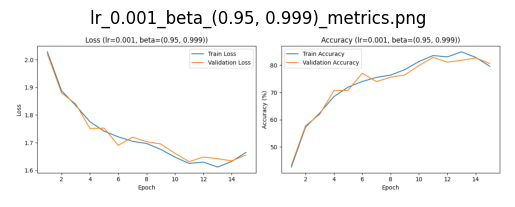

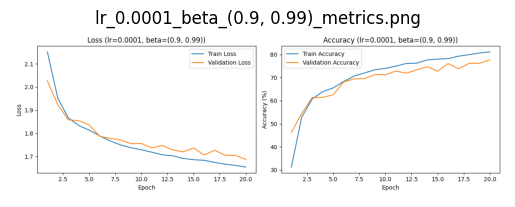

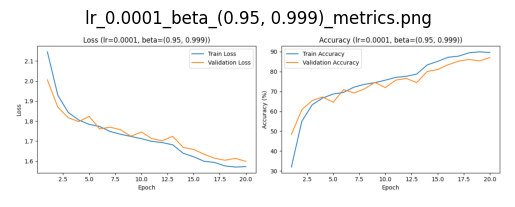

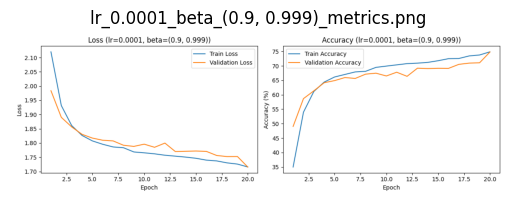

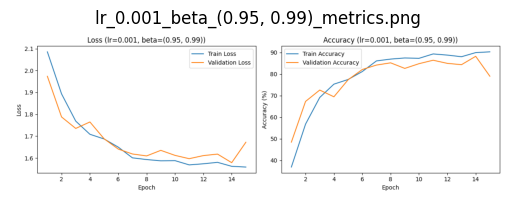

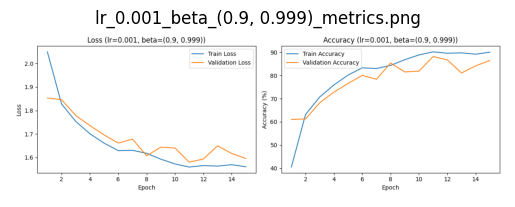

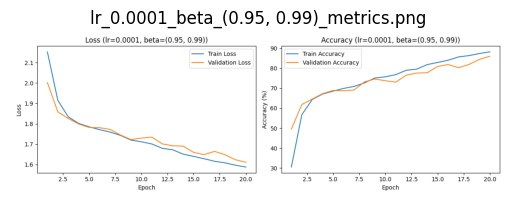

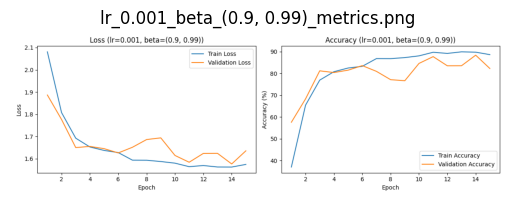

In [594]:
def plot_images_in_folder(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Filter out only image files
    image_files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
    
    # Plot each image
    for image_file in image_files:
        if image_file[:2] == 'lr':
            # Load the image
            image_path = os.path.join(folder_path, image_file)
            image = Image.open(image_path)
            
            # Plot the image
            plt.figure()
            plt.imshow(image)
            plt.title(image_file)
            plt.axis('off')
            plt.show()

# Path to your plots folder
plots_folder_path = 'plots'

# Call the function to plot images in the folder
plot_images_in_folder(plots_folder_path)

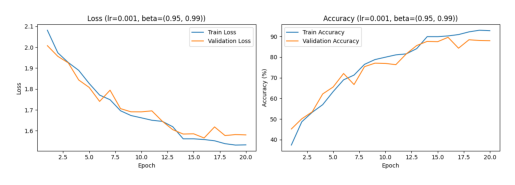

best epoch - 16


In [595]:
image = mpimg.imread("plots/best_train.png")
plt.imshow(image)
plt.axis('off') 
plt.show()

print("best epoch - 16")

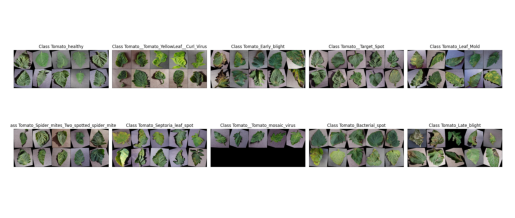

In [596]:
image = mpimg.imread("plots/predict.png")
plt.imshow(image)
plt.axis('off') 
plt.show()


In [597]:
df = pd.read_csv("classification/data.csv")


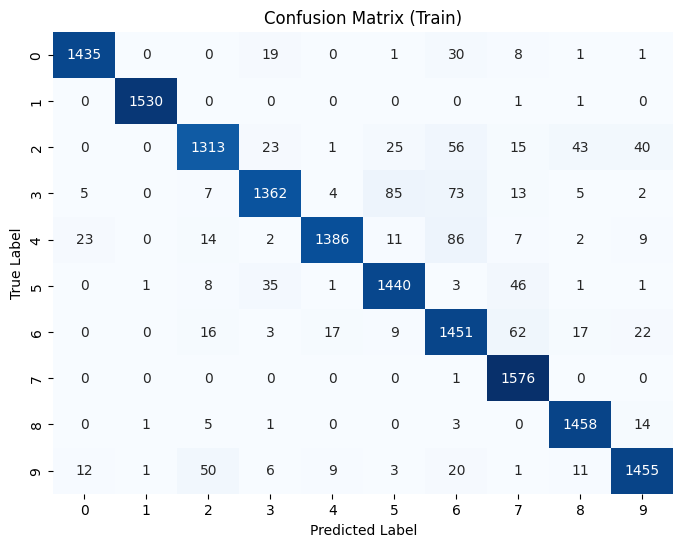

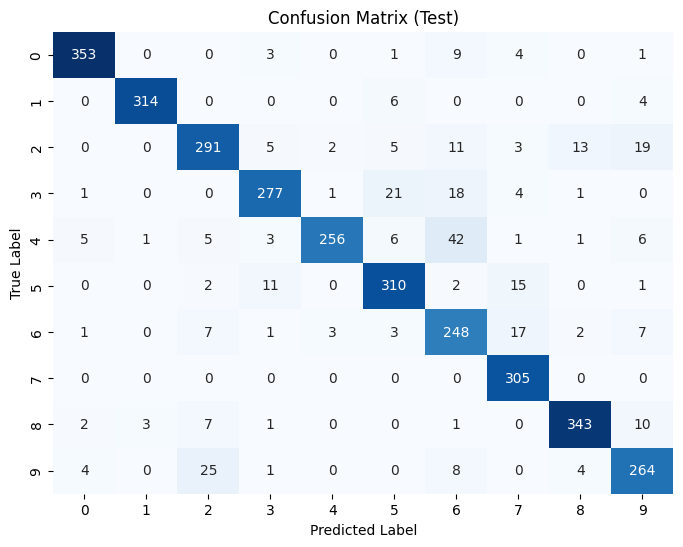

In [598]:
# Extract the relevant columns
real_labels = df['real_label']
pred_labels = df['pred_label']
train_labels = df['train']

# Compute the confusion matrix for both train and test
conf_matrix_train = confusion_matrix(real_labels[train_labels], pred_labels[train_labels])
conf_matrix_test = confusion_matrix(real_labels[~train_labels], pred_labels[~train_labels])

# Plot the confusion matrix for train data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [599]:

def evaluate_metrics(true_labels, predicted_labels, target_class =0 ):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    true_positives = np.diag(conf_matrix)
    false_positives = np.sum(conf_matrix, axis=0) - true_positives
    false_negatives = np.sum(conf_matrix, axis=1) - true_positives
    true_negatives = np.sum(conf_matrix) - (true_positives + false_positives + false_negatives)
    
    # Accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Precision
    precision = precision_score(true_labels, predicted_labels, average='macro')
    
    # Recall
    recall = recall_score(true_labels, predicted_labels, average='macro')
    
    # F1-score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    
    return accuracy, precision, recall, f1


# Extract true and predicted labels from the DataFrame
true_labels_train = df[df['train']]['real_label']
predicted_labels_train = df[df['train']]['pred_label']
true_labels_test = df[~df['train']]['real_label']
predicted_labels_test = df[~df['train']]['pred_label']

# Calculate metrics for train set
accuracy_train, precision_train, recall_train, f1_train = evaluate_metrics(true_labels_train, predicted_labels_train)

# Calculate metrics for test set
accuracy_test, precision_test, recall_test, f1_test = evaluate_metrics(true_labels_test, predicted_labels_test)

# Print the evaluation metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-score: {f1_train:.4f}")


print("Test Set Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-score: {f1_test:.4f}")



Train Set Metrics:
Accuracy: 0.9355
Precision: 0.9374
Recall: 0.9357
F1-score: 0.9358
Test Set Metrics:
Accuracy: 0.8970
Precision: 0.8984
Recall: 0.8962
F1-score: 0.8952


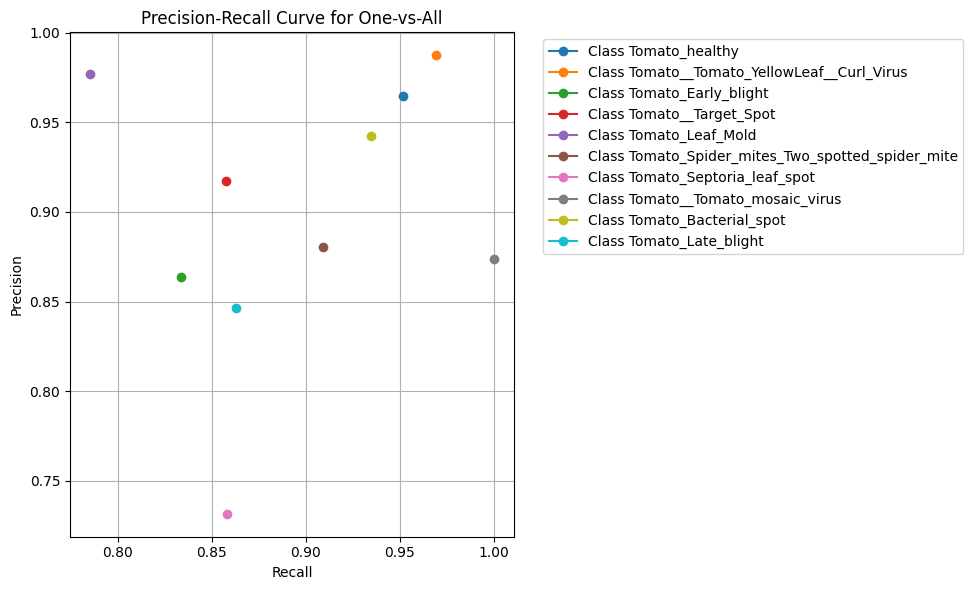

In [600]:

def one_vs_all_precision_recall(true_labels, predicted_labels, num_classes):
    precision_scores = []
    recall_scores = []

    for class_label in range(num_classes):
        # Treat class_label as the positive class and all other classes as negative
        true_labels_positive = (true_labels == class_label)
        predicted_labels_positive = (predicted_labels == class_label)

        precision = precision_score(true_labels_positive, predicted_labels_positive)
        recall = recall_score(true_labels_positive, predicted_labels_positive)

        precision_scores.append(precision)
        recall_scores.append(recall)

    return precision_scores, recall_scores

# Assuming you have true labels and predicted labels for the test set
# Replace these placeholders with your actual labels
true_labels_test = df[~df['train']]['real_label']
predicted_labels_test = df[~df['train']]['pred_label']

# Calculate precision and recall for one-vs-all approach
num_classes = len(df['real_label'].unique())  # Number of unique classes in the dataset
precision_scores, recall_scores = one_vs_all_precision_recall(true_labels_test, predicted_labels_test, num_classes)

# Plot precision and recall together
plt.figure(figsize=(10, 6))
for class_label in range(num_classes):
    plt.plot(recall_scores[class_label], precision_scores[class_label], marker='o', linestyle='-', label=f'Class {NUM_2_CLASS[class_label]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for One-vs-All')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Autoencoder Anomaly Detection

In [701]:
%load_ext autoreload
%autoreload 2
from autoencoder import AutoencoderDataSet, Autoencoder, generate_output_dataframe
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [742]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = AutoencoderDataSet(n_samples_from_each_class=26, transform=transform)

train_dataset, val_dataset, test_dataset = dataset.get_splits(train_size=0.7, val_size=0.3)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

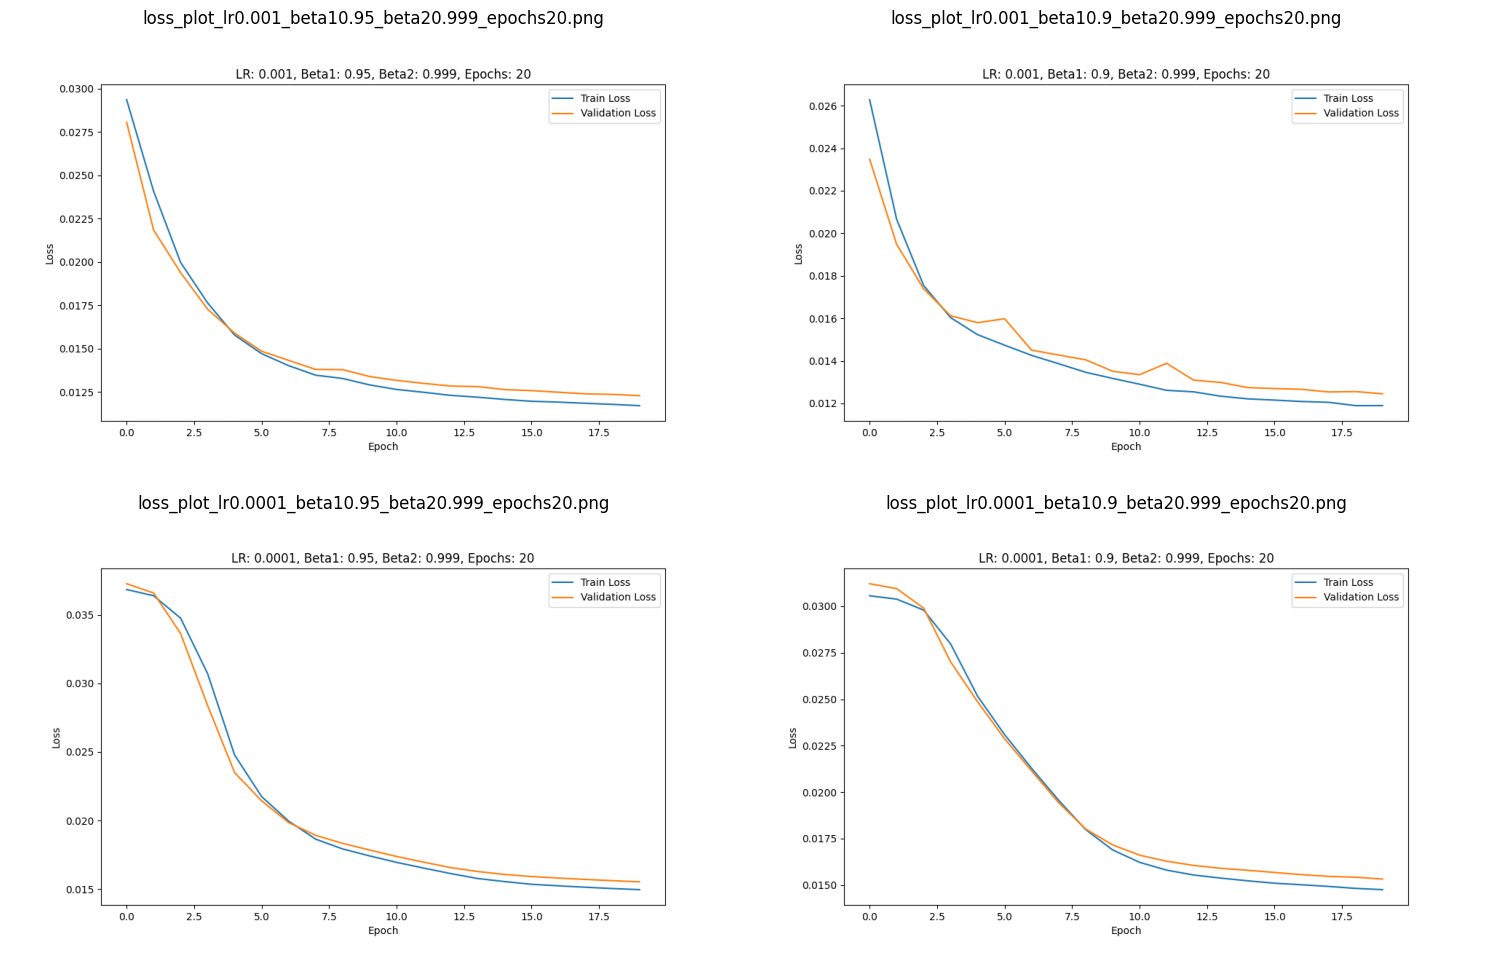

In [603]:
from PIL import Image

autoencoder_results_folder = 'results/autoencoder/'
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  

for ax, img_name in zip(axs, os.listdir(autoencoder_results_folder)):
    img_path = os.path.join(autoencoder_results_folder, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_name)
    ax.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()

In [604]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.95, 0.999))

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}')

Epoch 1, Validation Loss: 0.024864871753379703
Epoch 2, Validation Loss: 0.02088485425338149
Epoch 3, Validation Loss: 0.01842387579381466
Epoch 4, Validation Loss: 0.01696900138631463
Epoch 5, Validation Loss: 0.016028859303332865
Epoch 6, Validation Loss: 0.015508283046074212
Epoch 7, Validation Loss: 0.015031690243631601
Epoch 8, Validation Loss: 0.014847017941065133
Epoch 9, Validation Loss: 0.014509061467833817
Epoch 10, Validation Loss: 0.014232743182219565
Epoch 11, Validation Loss: 0.013892376096919179
Epoch 12, Validation Loss: 0.013842954533174634
Epoch 13, Validation Loss: 0.013454623986035585
Epoch 14, Validation Loss: 0.013285600929521024
Epoch 15, Validation Loss: 0.013164385221898556
Epoch 16, Validation Loss: 0.01302953774575144
Epoch 17, Validation Loss: 0.01292844326235354
Epoch 18, Validation Loss: 0.012865483178757131
Epoch 19, Validation Loss: 0.012766187894158065
Epoch 20, Validation Loss: 0.01269408653024584


In [606]:
torch.save(model.state_dict(), 'autoencoder_weights/best_model.pth')

In [609]:
model = Autoencoder()
model.load_state_dict(torch.load('autoencoder_weights/best_model.pth'))

<All keys matched successfully>

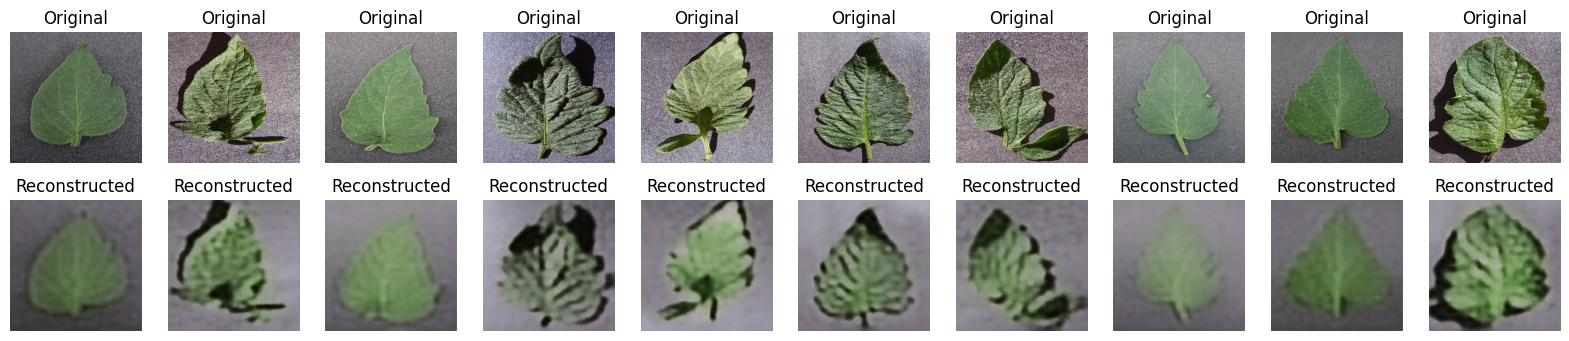

In [743]:
from autoencoder import visualize_reconstructions
model.eval()

images, _ = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    reconstructions = model(images)

visualize_reconstructions(images, reconstructions, n=10)  # Feel free to adjust n



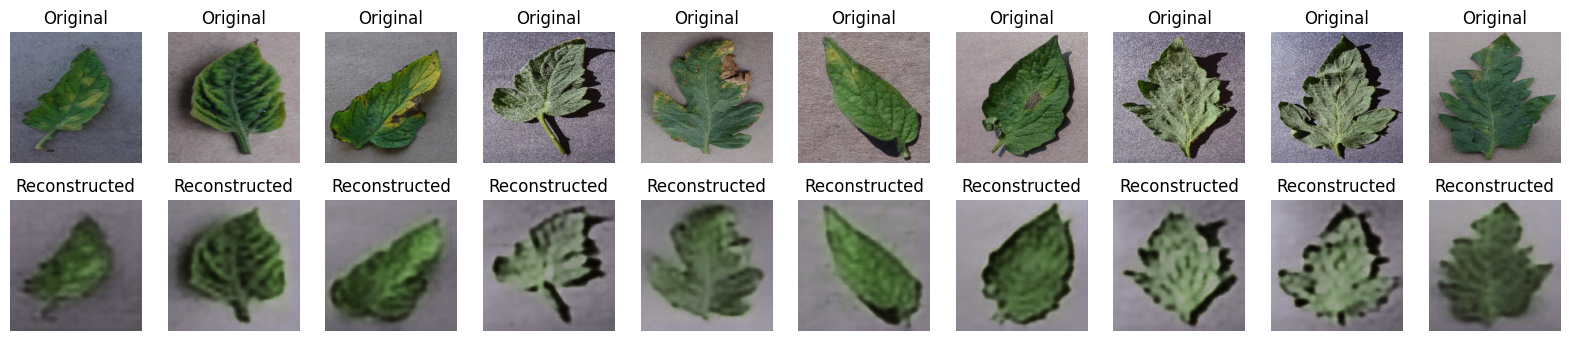

In [744]:
images, _ = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
    reconstructions = model(images)

visualize_reconstructions(images, reconstructions, n=10)


In [745]:
from autoencoder import generate_output_dataframe
mse_df = generate_output_dataframe(model, test_loader)

In [746]:
mse_df.head()

,image_idx,label,scaled_rgb_mse,scaled_hsv_mse,non_scaled_hsv_mse
0,0,9,0.009595,0.037094,2417.213623
1,1,0,0.019000,0.021794,1426.232422
2,2,0,0.004929,0.011746,762.699890
3,3,3,0.008488,0.014684,954.801270
4,4,0,0.015895,0.018173,1187.524170


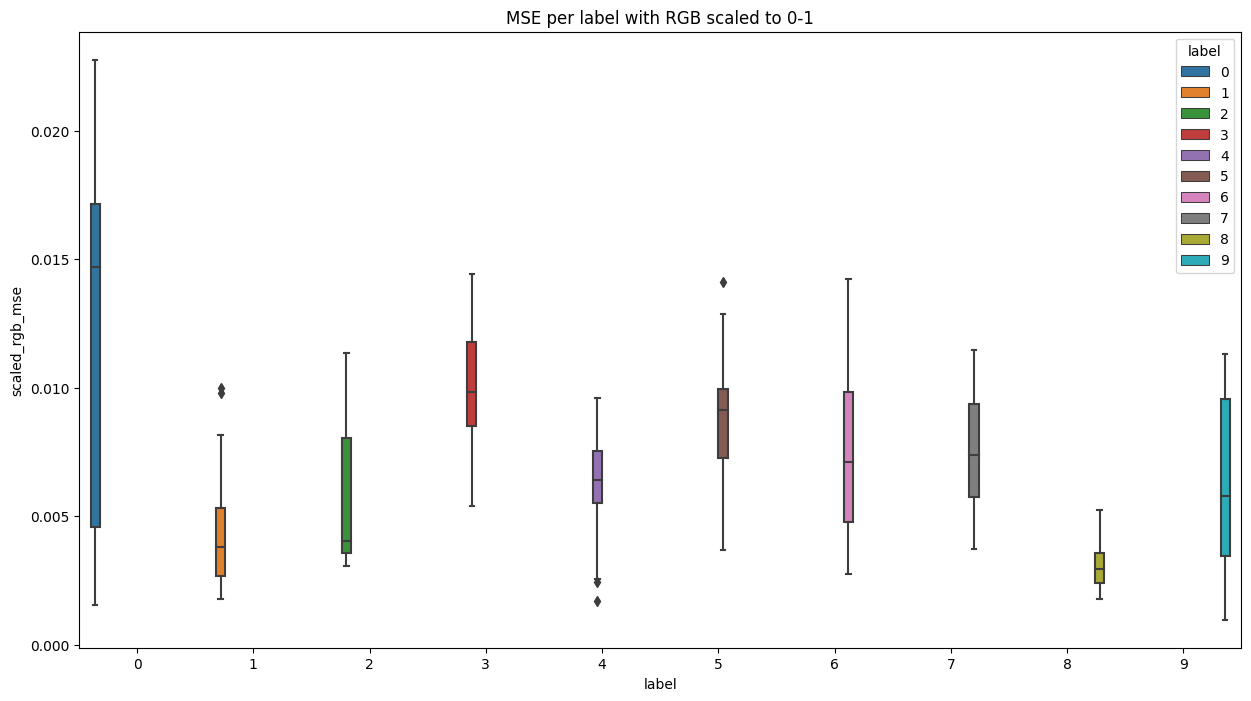

In [748]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(mse_df, x='label', y='scaled_rgb_mse' ,hue='label')
plt.title("MSE per label with RGB scaled to 0-1")
plt.show()

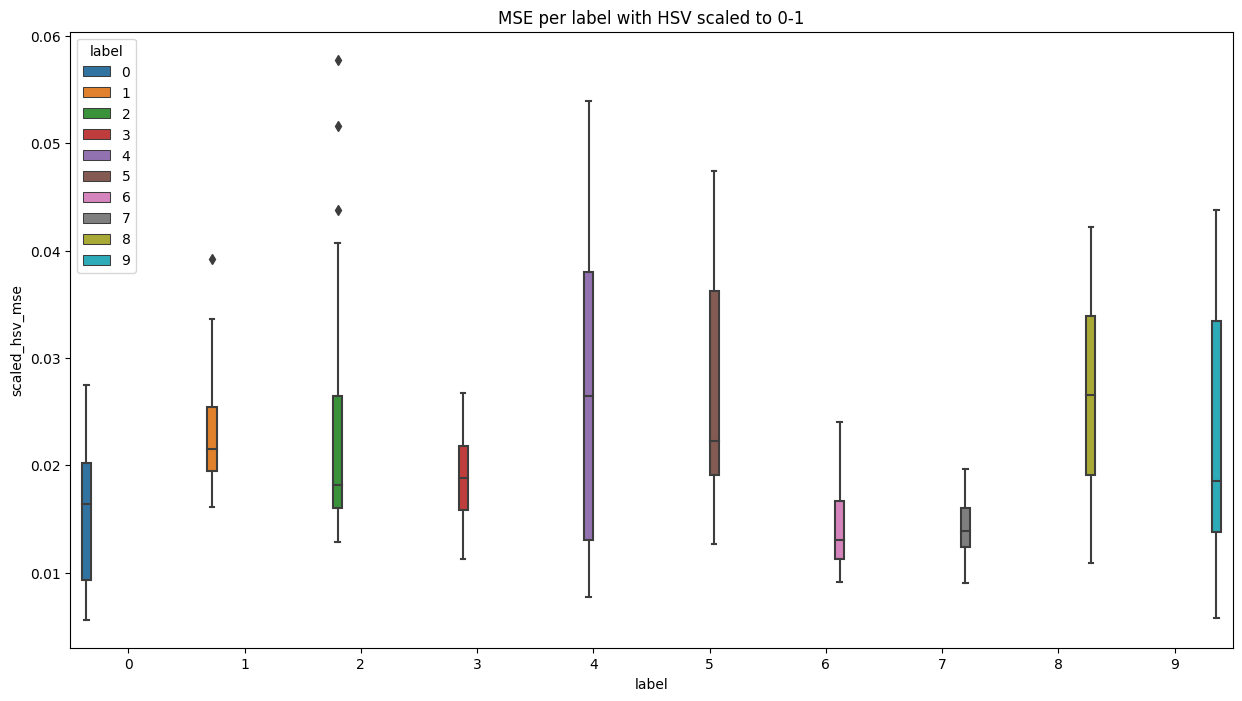

In [749]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(mse_df, x='label', y='scaled_hsv_mse' ,hue='label')
plt.title("MSE per label with HSV scaled to 0-1")
plt.show()

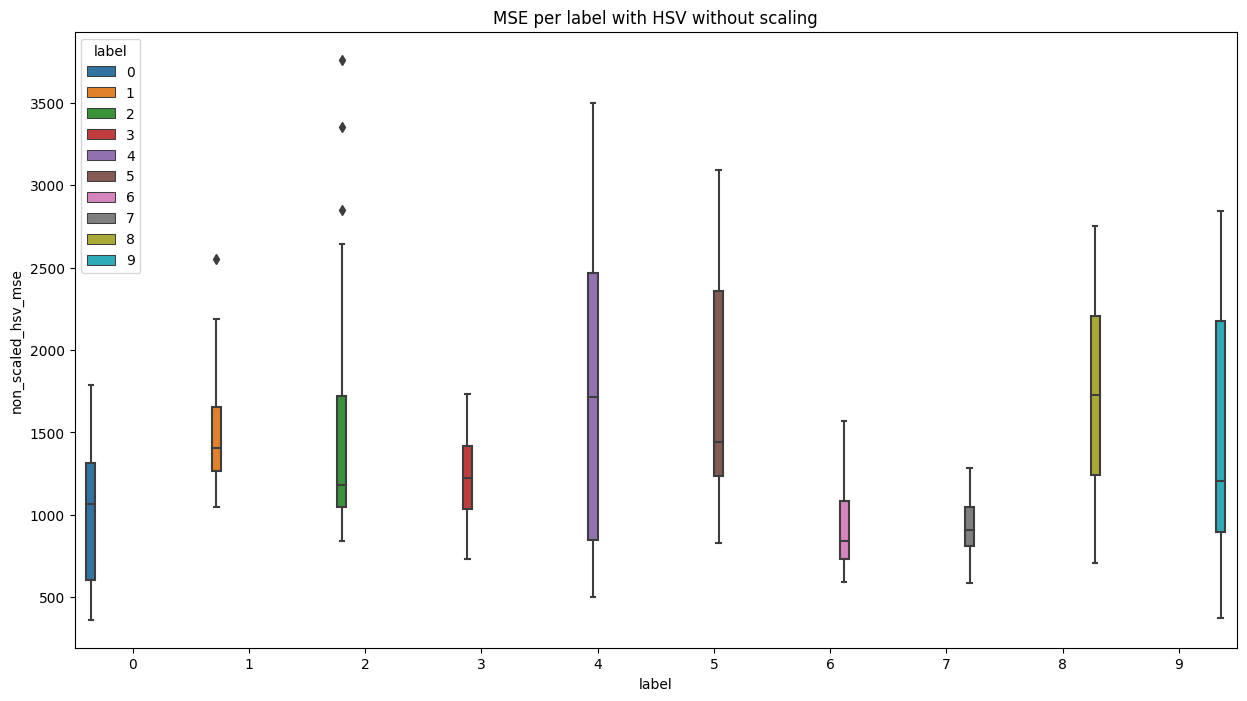

In [750]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(mse_df, x='label', y='non_scaled_hsv_mse' ,hue='label')
plt.title("MSE per label with HSV without scaling")
plt.show()

In [751]:
mse_df['binary_label'] = mse_df['label'].apply(lambda x: 0 if x==0 else 1)

In [767]:
healthy_25_percentile = mse_df.query("label == 0").non_scaled_hsv_mse.quantile(0.25)
healthy_75_percentile = mse_df.query("label == 0").non_scaled_hsv_mse.quantile(0.75)

print("0.25 percentile: ", healthy_25_percentile)
print("0.75 percentile: ", healthy_75_percentile)

0.25 percentile:  602.6374206542969
0.75 percentile:  1315.7722778320312


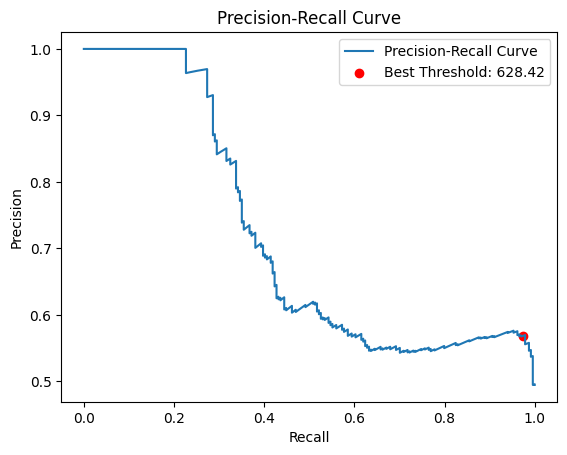

Best Threshold: 628.4190063476562


In [756]:
mse_scores = mse_df['non_scaled_hsv_mse']
true_labels = mse_df['binary_label']

precision, recall, thresholds = precision_recall_curve(true_labels, mse_scores)

# Calculate F1 scores
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
# Corresponding best threshold
best_threshold = thresholds[max_f1_index]

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(recall[max_f1_index+1], precision[max_f1_index+1], color='red', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print(f'Best Threshold: {best_threshold}')